<a href="https://colab.research.google.com/github/tewei0328/TS/blob/master/TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-1 LSTM
**【RNN/LSTM/GRU】**
- Recurrent Neural Network（RNN）是神經網絡的一種，常應用在處理時間、空間序列上有強關聯的訊息，尤其在 NLP （Natural Language Processing，自然語言處理）領域上，有趣的應用如語音識別、翻譯、描述照片、作曲等等。

- RNN 有其缺點：無法捕捉長期時間（當序列的距離太大）之間的關聯。簡單的 RNN 結構無法處理隨著遞歸權重指數級爆炸或消失的問題（Vanishing gradient problem）。

- 基於上RNN 的限制，可以透過 RNN 的變形，也就是 LSTM 來解決。LSTM 的特色是能夠學習長距離的依賴關係（Long-Term Dependencies），它不同於 RNN 有個單一的神經網絡層（tanh），而是有四個層。

- GRU 為 LSTM 的變形，它將遺忘和輸入門組合成一個 Update gate。它還合併了單元狀態和隱藏狀態，並進行了一些其他更改。由此產生的模型比標準 LSTM 模型簡單，並且越來越受歡迎。

**References:**
- [實戰系列] 使用 Keras 搭建一個 LSTM 魔法陣（模型）
  - https://ithelp.ithome.com.tw/articles/10206312

In [1]:
# Step 1: 資料前處理
# Load Data：
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

In [23]:
# Import the training set
#dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')  # 讀取訓練集
import pandas_datareader as pdr
startTime = '2019-01-01'
endTime = '2020-06-30'
dataset_train = pdr.DataReader('^TWII', 'yahoo', startTime, endTime)
# dataset_train = pdr.DataReader('^TWII', 'yahoo')
training_set = dataset_train.iloc[:, 1:2].values  # 取「Open」欄位值

In [24]:
dataset_train.shape

(358, 6)

## 觀念1: iloc (Pandas)
https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/462517/

In [9]:
dataset_train.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-13,9041.879883,8946.719727,8946.719727,9033.919922,2077600.0,9033.886719
2015-07-14,9124.759766,9041.759766,9061.580078,9041.759766,2139300.0,9041.726562
2015-07-15,9089.469727,9005.099609,9063.540039,9054.200195,1789400.0,9054.166992
2015-07-16,9085.309570,9021.820312,9062.759766,9042.209961,1666800.0,9042.176758
2015-07-17,9079.230469,9018.000000,9060.919922,9045.980469,1615500.0,9045.947266


In [10]:
dataset_train.Low.head()

Date
2015-07-13    8946.719727
2015-07-14    9041.759766
2015-07-15    9005.099609
2015-07-16    9021.820312
2015-07-17    9018.000000
Name: Low, dtype: float64

In [7]:
dataset_train.iloc[:, 1:2].values #取第二欄資料:low

array([[ 8946.71972656],
       [ 9041.75976562],
       [ 9005.09960938],
       ...,
       [12083.83984375],
       [12181.33984375],
       [12030.20019531]])

In [3]:
# 做 Normalization，將資料壓縮在 [0,1] 之間：
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# training_set_scaled

array([[0.35025218],
       [0.36934315],
       [0.36197912],
       ...,
       [0.98041488],
       [1.        ],
       [0.96964013]])

In [4]:
# 準備進入訓練的資料格式：設定 Timestep
# Timesteps 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, 1200):  # 1258 是訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

##  觀念2: Numpy Array
- 建立了基本的 array 和 ndarray 的觀念。相信在熟悉 Numpy 之後 Pandas 的學習將會比較容易 （Pandas 的資料容器 DataFrame、Series 事實上是奠基在 Numpy 的陣列上）
  - https://blog.techbridge.cc/2017/07/28/data-science-101-numpy-tutorial/
  ![Alt text](https://static.coderbridge.com/img/techbridge/images/kdchang/axis.png)
- numpy.reshape()
我們先來看看會在各種資料計算中經常用到的改變陣列形狀的函式 reshape()。
  import numpy as np
  arrayA = np.arange(8)
  * arrayA = array([0, 1, 2, 3, 4, 5, 6, 7])

  np.reshape(arrayA, (2, 4))
  * array([[0, 1, 2, 3],
  *       [4, 5, 6, 7]])
  - https://www.delftstack.com/zh-tw/tutorial/python-numpy/numpy-array-reshape-and-resize/


In [12]:
training_set_scaled[0,0] #只有一欄, 所以第二項永為0

0.35025217505335937

In [6]:
training_set_scaled[1,0]

0.3693431521778683

In [14]:
X_train.shape[0]

1140

In [15]:
X_train.shape[1]

60

In [13]:
# Reshape
# 因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
X_train

array([[[0.35025218],
        [0.36934315],
        [0.36197912],
        ...,
        [0.21105327],
        [0.22372436],
        [0.23860092]],

       [[0.36934315],
        [0.36197912],
        [0.36533785],
        ...,
        [0.22372436],
        [0.23860092],
        [0.23742589]],

       [[0.36197912],
        [0.36533785],
        [0.36457046],
        ...,
        [0.23860092],
        [0.23742589],
        [0.24736107]],

       ...,

       [[0.43554885],
        [0.40487962],
        [0.26526485],
        ...,
        [0.87064584],
        [0.88744678],
        [0.86646968]],

       [[0.40487962],
        [0.26526485],
        [0.32416693],
        ...,
        [0.88744678],
        [0.86646968],
        [0.81184223]],

       [[0.26526485],
        [0.32416693],
        [0.31076455],
        ...,
        [0.86646968],
        [0.81184223],
        [0.82285219]]])

In [17]:
# Step 2: 搭建一個 LSTM 魔法陣
# import Keras
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

Using TensorFlow backend.


## 搭建 LSTM layer:
- units: 神經元的數目
- 第一層的 LSTM Layer 記得要設定input_shape參數
- 搭配使用dropout，這裡設為 0.2
- 由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [18]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [19]:
# Ouput Layer: units 設為 1
# Adding the output layer
regressor.add(Dense(units = 1))

In [20]:
# Compiling & Fitting LSTM model
# optimizer: 選擇 Adam
# loss: 使用 MSE
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1140/1140 [==============================] - 7s 6ms/step - loss: 0.0616
Epoch 2/100
1140/1140 [==============================] - 5s 5ms/step - loss: 0.0102
Epoch 3/100
1140/1140 [==============================] - 5s 5ms/step - loss: 0.0083
Epoch 4/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0091
Epoch 5/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0089
Epoch 6/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0078
Epoch 7/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0073
Epoch 8/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0073
Epoch 9/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0077
Epoch 10/100
1140/1140 [==============================] - 5s 4ms/step - loss: 0.0072
Epoch 11/100
1140/1140 [==============================] - 5s 5ms/step - loss: 0.0063
Epoch 12/100
1140/1140 [==============================] - 5s 4ms/step - lo

# 4-2 LSTM
LTSMs and recurrent neural networks are as a result good at working with time series data thanks to their ability to remember the past. By storing some of the old state in these recurrent nodes, RNNs and LSTMs can reason about current information as well as information the network had seen one, ten or a thousand steps ago. 

**References**
- 1.利用Keras建構LSTM模型，以Stock Prediction 為例

  - https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b

- 2.[實戰系列] 使用 Keras 搭建一個 LSTM 魔法陣（模型）
  - https://ithelp.ithome.com.tw/articles/10206312

- 3.Predicting stock prices using deep learning  
  - https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe

  - GitHub:
https://github.com/tewei0328/stock-trading-ml

In [ ]:
#1. 匯入套件
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


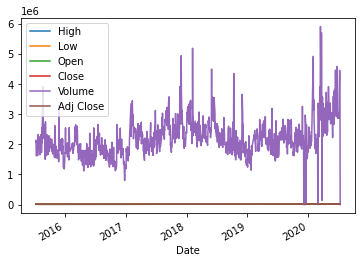

In [ ]:
#2. 讀取資料
import pandas_datareader as pdr
train = pdr.DataReader('^TWII', 'yahoo')
train.plot()

In [ ]:
def readTrain():
  # train = pd.read_csv("SPY.csv")
  train = pdr.DataReader('^TWII', 'yahoo')
  train['Date']=train.index
  return train

In [ ]:
#train.head()

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2015-07-09,8946.240234,8750.919922,8861.280273,8914.129883,2589100.0,8914.096680,2015-07-09
2015-07-13,9041.879883,8946.719727,8946.719727,9033.919922,2077600.0,9033.886719,2015-07-13
2015-07-14,9124.759766,9041.759766,9061.580078,9041.759766,2139300.0,9041.726562,2015-07-14
2015-07-15,9089.469727,9005.099609,9063.540039,9054.200195,1789400.0,9054.166992,2015-07-15
2015-07-16,9085.309570,9021.820312,9062.759766,9042.209961,1666800.0,9042.176758,2015-07-16


In [ ]:
#train.index

DatetimeIndex(['2015-07-09', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-20', '2015-07-21',
               '2015-07-22', '2015-07-23',
               ...
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-29',
               '2020-06-30', '2020-07-01', '2020-07-02', '2020-07-03',
               '2020-07-06', '2020-07-07'],
              dtype='datetime64[ns]', name='Date', length=1214, freq=None)

## 【實用但常忘記的pandas指令】
1. df.set_index('time',inplace=True)
2. df.index=df['Date'] 
3. df['Date']=df.index
4. df.drop(['Date'],axis=1,inplace=True)
5.train["Date"] = pd.to_datetime(train["Date"])
6.train["year"] = train["Date"].dt.year
7.train["month"] = train["Date"].dt.month
8.train["date"] = train["Date"].dt.day
9.train["day"] = train["Date"].dt.dayofweek

In [ ]:
#train['Date']=train.index

In [ ]:
#Augment Features (除了基本資料提供的Features(Open, High, Low, Close, Adj Close, Volume)以外，還可自己增加Features，例如星期幾、幾月、幾號等等。)
def augFeatures(train):
  train["Date"] = pd.to_datetime(train["Date"])
  train["year"] = train["Date"].dt.year
  train["month"] = train["Date"].dt.month
  train["date"] = train["Date"].dt.day
  train["day"] = train["Date"].dt.dayofweek
  return train

In [ ]:
#train_Aug = augFeatures(train)

In [ ]:
#train_Aug.head()

,High,Low,Open,Close,Volume,Adj Close,Date,year,month,date,day
Date,,,,,,,,,,,
2015-07-13,9041.879883,8946.719727,8946.719727,9033.919922,2077600.0,9033.886719,2015-07-13,2015,7,13,0
2015-07-14,9124.759766,9041.759766,9061.580078,9041.759766,2139300.0,9041.726562,2015-07-14,2015,7,14,1
2015-07-15,9089.469727,9005.099609,9063.540039,9054.200195,1789400.0,9054.166992,2015-07-15,2015,7,15,2
2015-07-16,9085.309570,9021.820312,9062.759766,9042.209961,1666800.0,9042.176758,2015-07-16,2015,7,16,3
2015-07-17,9079.230469,9018.000000,9060.919922,9045.980469,1615500.0,9045.947266,2015-07-17,2015,7,17,4


In [ ]:
# Normalization (將所有資料做正規化，而由於Date 是字串非數字，因此先將它drop掉)
def normalize(train):
  train = train.drop(["Date"], axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm

In [ ]:
# 資料亂序 (將資料打散，而非照日期排序)
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [ ]:
# Training data & Validation data (將Training Data取一部份當作Validation Data)
def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [ ]:
# Build Training Data
# 輸入X_train: 利用前30天的Open, High, Low, Close, Adj Close, Volume, month, year, date, day作為Features，shape為(30, 10)
# 輸出Y_train: 利用未來5天的Adj Close作為Features，shape為(5,1)
# 我們須將資料做位移的展開作為Training Data
def buildTrain(train, pastDay=30, futureDay=5):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Adj Close"]))
  return np.array(X_train), np.array(Y_train)

In [ ]:
# 因此最後將輸出合併為
# read SPY.csv
train = readTrain()

# Augment the features (year, month, date, day)
train_Aug = augFeatures(train)

# Normalization
train_norm = normalize(train_Aug)

# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(train_norm, 30, 5)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
# X_trian: (5710, 30, 10)
# Y_train: (5710, 5, 1)
# X_val: (634, 30, 10)
# Y_val: (634, 5, 1)

In [ ]:
# 一對一模型
# 由於是一對一模型，因此return_sequences 也可設為False ，但Y_train 以及Y_val的維度需改為二維(5710,1)以及(634,1) 。
def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [ ]:
# 將過去的天數pastDay設為1，預測的天數futureDay也設為1
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

model = buildOneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(1, 10))`
  """


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Train on 1092 samples, validate on 121 samples
Epoch 1/1000
1092/1092 [==============================] - 1s 609us/step - loss: 0.0401 - val_loss: 0.0421
Epoch 2/1000
1092/1092 [==============================] - 0s 25us/step - loss: 0.0358 - val_loss: 0.0376
Epoch 3/1000
1092/1092 [==============================] - 0s 25us/step - loss: 0.0314 - val_loss: 0.0328
Epoch 4/1000
1092/1092 [==============================] - 0s 24us/step - loss: 0.0275 - val_loss: 0.0285
Epoch 5/1000
1092/1092 [==========================

In [ ]:
#多對一模型
#LSTM參數return_sequences=False ，未設定時default也為False，而且不可使用TimeDistribution
def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [ ]:
#需要設定的有pastDay=30、future=1 ，且注意Y_train 的維度需為二維
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 30, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(30, 10))`
  """


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Train on 1066 samples, validate on 118 samples
Epoch 1/1000
1066/1066 [==============================] - 1s 508us/step - loss: 0.0519 - val_loss: 0.0405
Epoch 2/1000
1066/1066 [==============================] - 0s 147us/step - loss: 0.0324 - val_loss: 0.0239
Epoch 3/1000
1066/1066 [==============================] - 0s 133us/step - loss: 0.0178 - val_loss: 0.0120
Epoch 4/1000
1066/1066 [==============================] - 0s 134us/step - loss: 0.0092 - val_loss: 0.0068
Epoch 5/1000
1066/1066 [=======================

In [ ]:
#一對多模型
#因為是一對多模型Timesteps只有1，因此return_sequences=False 才可執行
def buildOneToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (5, 1)
  model.add(Dense(1))
  model.add(RepeatVector(5))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [ ]:
#將pastDay 設為1, futureDay 設為5
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildOneToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(1, 10))`
  """


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 1)              0         
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Train on 1089 samples, validate on 120 samples
Epoch 1/1000
1089/1089 [==============================] - 0s 394us/step - loss: 0.0581 - val_loss: 0.0630
Epoch 2/1000
1089/1089 [==============================] - 0s 30us/step - loss: 0.0528 - val_loss: 0.0574
Epoch 3/1000
1089/1089 [==============================] - 0s 25us/step - loss: 0.0478 - val_loss: 0.0519
Epoch 4/1000
1089/1089 

In [ ]:
#多對多模型 (輸入與輸出相同長度)
#將return_sequences 設為True ，再用TimeDistributed(Dense(1)) 將輸出調整為(5,1)
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # output shape: (5, 1)
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [ ]:
#將pastDay 以及futureDay 設為相同長度5
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 5, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(5, 10))`
  """


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 1)              11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Train on 1085 samples, validate on 120 samples
Epoch 1/1000
1085/1085 [==============================] - 0s 431us/step - loss: 0.1257 - val_loss: 0.1105
Epoch 2/1000
1085/1085 [==============================] - 0s 41us/step - loss: 0.1053 - val_loss: 0.0935
Epoch 3/1000
1085/1085 [==============================] - 0s 38us/step - loss: 0.0886 - val_loss: 0.0789
Epoch 4/1000
1085/1085 [==============================] - 0s 40us/step - loss: 0.0744 - val_loss: 0.0661
Epoch 5/1000
1085/1085 [==========================

# 1. Remote Data Access
- 【pdr.DataReader】
  - startTime = '2018-10-01'
  - endTime = '2018-10-30'
  - df_2330 = pdr.DataReader('^TWII', 'yahoo', startTime, endTime)
  - df_2330.plot()

* 參考資料: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
* colab內已安裝有pandas_DataReader
* 參考資料: https://ithelp.ithome.com.tw/articles/10205113


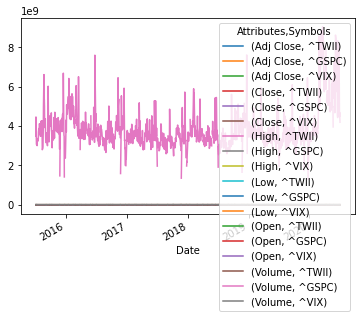

In [ ]:
import pandas_datareader as pdr
df_many = pdr.DataReader(['^TWII', '^GSPC', '^VIX'], 'yahoo')
df=df_many.Close
df_many.plot()

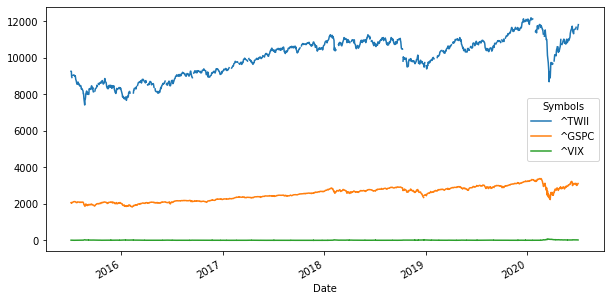

In [ ]:
df_many.Close.plot(figsize=(10,5))

In [ ]:
df['^GSPC*5']=df['^GSPC']*5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['^VIX*100']=df['^VIX']*100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

Symbols,^TWII,^GSPC,^VIX,^GSPC*5,^VIX*500
Date,,,,,
2015-07-06,9255.959961,2068.760010,17.010000,10343.800049,8505.000114
2015-07-07,9250.160156,2081.340088,16.090000,10406.700439,8045.000076
2015-07-08,8976.110352,2046.680054,19.660000,10233.400269,9829.999924
2015-07-09,8914.129883,2051.310059,19.969999,10256.550293,9984.999657
2015-07-10,NaN,2076.620117,16.830000,10383.100586,8414.999962
...,...,...,...,...,...
2020-06-26,NaN,3009.050049,34.730000,15045.250244,17364.999771
2020-06-29,11542.620117,3053.239990,31.780001,15266.199951,15890.000343
2020-06-30,11621.240234,3100.290039,30.430000,15501.450195,15215.000153


In [ ]:
#del df['^VIX*500']
del df['^GSPC']
del df['^VIX']

In [ ]:
df_many.Close

Symbols,^TWII,^GSPC,^VIX
Date,,,
2015-07-06,9255.959961,2068.760010,17.010000
2015-07-07,9250.160156,2081.340088,16.090000
2015-07-08,8976.110352,2046.680054,19.660000
2015-07-09,8914.129883,2051.310059,19.969999
2015-07-10,NaN,2076.620117,16.830000
...,...,...,...
2020-06-26,NaN,3009.050049,34.730000
2020-06-29,11542.620117,3053.239990,31.780001
2020-06-30,11621.240234,3100.290039,30.430000


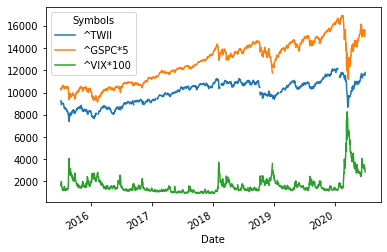

In [ ]:
df.plot()

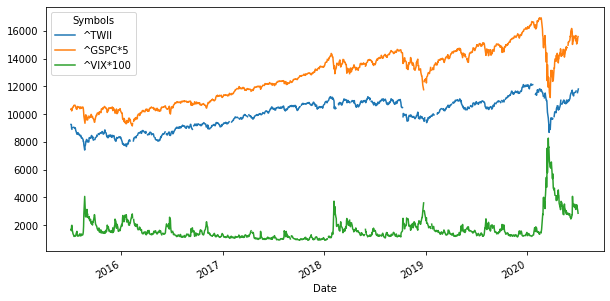

In [ ]:
df.plot(figsize=(10,5))

# 2. Fourier Transform
* 傅立葉發現任意複雜的信號都能由一個個混合在一起的正弦函數的和來表示
* 參考程式碼: https://github.com/tewei0328/stockpredictionai#fouriertransform
* 只用幾項sine waves就可來近似原函數: https://kknews.cc/education/j934zvq.html
* 原理介紹: https://kknews.cc/education/p6qjkxp.html

In [ ]:
import pandas_datareader as pdr
df_many = pdr.DataReader(['^TWII', '^GSPC', '^VIX'], 'yahoo')
df=df_many.Close

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


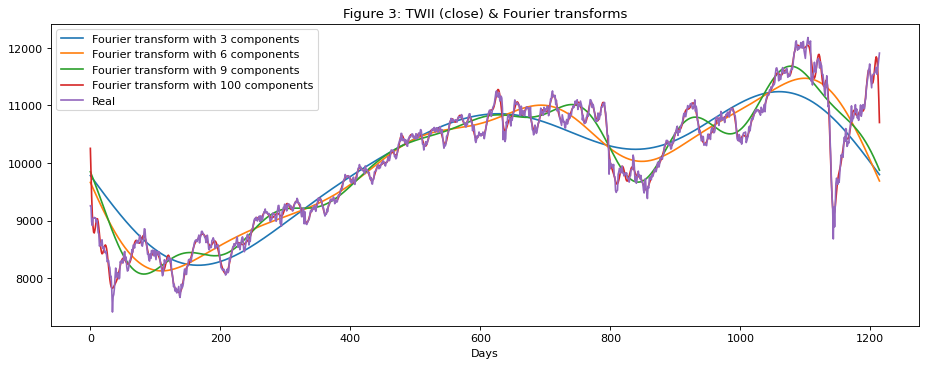

In [ ]:
""" Code to create the Fuorier trasfrom  """
#-----------------------------------------------
#1.要先將series資料轉成list, 再轉成np的array, 如此才能使用np的fast Fourier transform
data_FT = df['^TWII']
data_FT=data_FT.dropna() #除去空值, 否則fft會跑不出來結果
close_fft = np.fft.fft(np.asarray(data_FT.tolist()))
#-----------------------------------------------
#2.畫圖前, 要先將資料載回dataframe
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x)) # 取出大小
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))  # 取出角度
plt.figure(figsize=(14, 5), dpi=80)

fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

plt.plot(data_FT.to_list(),  label='Real') #將series轉成list, 去除時間，才能和其他不帶時間的資料一起畫圖
plt.xlabel('Days')
plt.ylabel('')
plt.title('Figure 3: TWII (close) & Fourier transforms')
plt.legend()

In [ ]:
data_FT.head()

Date
2015-07-06    9255.959961
2015-07-07    9250.160156
2015-07-08    8976.110352
2015-07-09    8914.129883
2015-07-13    9033.919922
Name: ^TWII, dtype: float64

In [ ]:
fft_df.head()

,fft,absolute,angle
0,1.217113e+07+0.000000e+00j,1.217113e+07,0.000000
1,-2.816083e+05+5.756518e+05j,6.408418e+05,2.025766
2,1.789546e+05+4.115206e+05j,4.487471e+05,1.160602
3,-8.081201e+04+2.648527e+05j,2.769071e+05,1.866944
4,-4.529803e+04+7.561839e+04j,8.814790e+04,2.110506


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


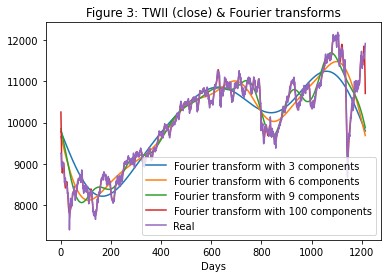

In [ ]:
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

plt.plot(data_FT.to_list(),  label='Real') #將series轉成list, 去除時間，才能和其他不帶時間的資料一起畫圖
plt.xlabel('Days')
plt.ylabel('')
plt.title('Figure 3: TWII (close) & Fourier transforms')
plt.legend()


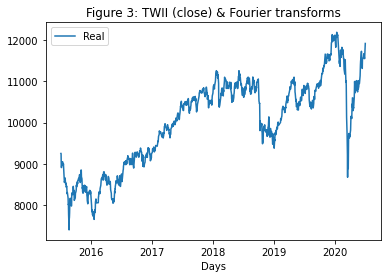

In [ ]:
plt.plot(data_FT,  label='Real')
plt.xlabel('Days')
plt.ylabel('')
plt.title('Figure 3: TWII (close) & Fourier transforms')
plt.legend()
plt.show()

#3. HMM
**Hidden Markov Model**
In a Hidden Markov Model (HMM), we have an invisible Markov chain (which we cannot observe), and each state generates in random one out of k observations, which are visible to us.

**_Let’s look at an example. Suppose we have the Markov Chain from above, with three states (snow, rain and sunshine), P - the transition probability matrix and q — the initial probabilities. This is the invisible Markov Chain — suppose we are home and cannot see the weather. We can, however, feel the temperature inside our room, and suppose there are two possible observations: hot and cold._**
* 參考資料: https://xinyileo.github.io/StockHMM/
* 參考資料(Github): https://github.com/tewei0328/TS/blob/master/TS_HMM.ipynb
* 參考程式碼: https://github.com/XinyiLeo/StockHMM/blob/master/hmmestimate.py
* 理論介紹: https://towardsdatascience.com/introduction-to-hidden-markov-models-cd2c93e6b781
* 傳說中的 **Baum-Welch Algorithm**:
  * A similar approach to the one above can be used for parameter learning of the HMM model. We have some dataset, and we want to find the parameters which fit the HMM model best. The Baum-Welch Algorithm is an iterative process which finds a (local) maximum of the probability of the observations P(O|M), where M denotes the model (with the parameters we want to fit). Since we know P(M|O) by the model, we can use a Bayesian approach to find P(M|O) and converge to an optimum.
 

## 【隱藏式馬可夫模型 HMM】
隱藏式馬可夫模型（Hidden Markov Model；縮寫：HMM）或稱作隱性馬可夫模型，是統計模型，它用來描述一個含有隱含未知參數的馬可夫過程。其難點是從可觀察的參數中確定該過程的隱含參數。然後利用這些參數來作進一步的分析，例如圖型識別。

在正常的馬可夫模型中，狀態對於觀察者來說是直接可見的。這樣狀態的轉換機率便是全部的參數。而在隱藏式馬可夫模型中，狀態並不是直接可見的，但受狀態影響的某些變數則是可見的。每一個狀態在可能輸出的符號上都有一機率分布。因此輸出符號的序列能夠透露出狀態序列的一些資訊。
https://zh.wikipedia.org/wiki/%E9%9A%90%E9%A9%AC%E5%B0%94%E5%8F%AF%E5%A4%AB%E6%A8%A1%E5%9E%8B

.
## 【馬可夫過程】
在機率論及統計學中，馬可夫過程（英語：Markov process）是一個具備了馬可夫性質的隨機過程，因為俄國數學家安德雷·馬可夫得名。馬可夫過程是不具備記憶特質的（memorylessness）。換言之，馬可夫過程的條件機率僅僅與系統的當前狀態相關，而與它的過去歷史或未來狀態，都是獨立、不相關的[1]。

具備離散狀態的馬可夫過程，通常被稱為馬可夫鏈。馬可夫鏈通常使用離散的時間集合定義，又稱離散時間馬可夫鏈[2]。有些學者雖然採用這個術語，但允許時間可以取連續的值[3]。
https://zh.wikipedia.org/wiki/%E9%A6%AC%E5%8F%AF%E5%A4%AB%E9%81%8E%E7%A8%8B

## 【HMM for time series】
Hidden Markov models for time series classification — basic overview
https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b


In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 368kB 2.8MB/s 


In [ ]:
import datetime

import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import scale
import pandas_datareader.data as web

start = datetime.datetime(2016, 1, 1)
end = datetime.date.today()
apple = web.DataReader("AAPL", "morningstar", start, end)

dates = np.array(apple["Close"].index.levels[1])
close_v = np.array(apple["Close"].values)
volume = np.array(apple["Volume"].values)[1:]

# Get the variation of the price
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

# Scale: Normalize
# Input the stock return and
X = np.column_stack([scale(diff), scale(volume)])

# Train Gaussian Model, Assume 4 hidden states
model = GaussianHMM(n_components=4, covariance_type="full", n_iter=20)
model.fit(X)

# Prediction the hidden layers
hidden_states = model.predict(X)

# Print the parameters
print("Transition matrix: ", model.transmat_)
print("Means and vars of each hidden state")
for i in range(4):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", model.covars_[i])
print()

fig, axs = plt.subplots(4, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, 4))

one_layer = []
two_layer = []
three_layer = []
fourth_layer = []

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

In [ ]:
  import datetime
  import numpy as np
  from matplotlib import cm, pyplot as plt
  from matplotlib.dates import YearLocator, MonthLocator
  from hmmlearn.hmm import GaussianHMM
  from sklearn.preprocessing import scale
  import pandas_datareader.data as web

  start = datetime.datetime(2016, 1, 1)
  end = datetime.date.today()
  apple = web.DataReader("AAPL", "yahoo", start, end)

  #dates = np.array(apple["Close"].index.levels[1])
  dates = np.array(apple["Close"].index)
  close_v = np.array(apple["Close"].values)
  volume = np.array(apple["Volume"].values)[1:]

  # Get the variation of the price
  diff = np.diff(close_v)
  dates = dates[1:]
  close_v = close_v[1:]

  # Scale: Normalize
  # Input the stock return and
  X = np.column_stack([scale(diff), scale(volume)])

  # Train Gaussian Model, Assume 4 hidden states
  model = GaussianHMM(n_components=4, covariance_type="full", n_iter=20)
  model.fit(X)

  # Prediction the hidden layers
  hidden_states = model.predict(X)

Transition matrix:  [[8.39058927e-01 2.11293248e-04 1.29942029e-01 3.07877508e-02]
 [2.28728382e-08 6.65582942e-01 6.98159739e-02 2.64601061e-01]
 [1.83564769e-01 5.87080993e-03 6.60645206e-01 1.49919216e-01]
 [2.65359159e-03 6.37648263e-02 3.76949783e-01 5.56631799e-01]]
Means and vars of each hidden state
0th hidden state
mean =  [ 0.01579281 -0.70299858]
var =  [[ 0.11703306 -0.00356137]
 [-0.00356137  0.07468394]]
1th hidden state
mean =  [-0.45465912  2.99597256]
var =  [[10.13878143 -0.52522792]
 [-0.52522792  1.47398695]]
2th hidden state
mean =  [ 0.07290683 -0.04412322]
var =  [[ 0.44073196 -0.02754038]
 [-0.02754038  0.13818789]]
3th hidden state
mean =  [-0.07602764  1.00805421]
var =  [[ 1.92601458 -0.06001097]
 [-0.06001097  0.46061979]]



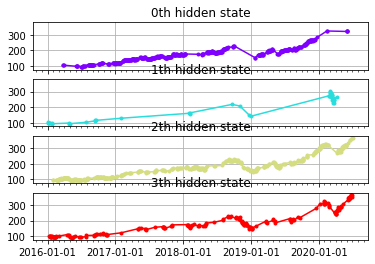

In [ ]:
# Print the parameters
print("Transition matrix: ", model.transmat_)
print("Means and vars of each hidden state")
for i in range(4):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", model.covars_[i])
print()

fig, axs = plt.subplots(4, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, 4))

one_layer = []
two_layer = []
three_layer = []
fourth_layer = []

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

In [ ]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,105.370003,102.000000,102.610001,105.349998,67649400.0,97.948441
2016-01-05,105.849998,102.410004,105.750000,102.709999,55791000.0,95.493919
2016-01-06,102.370003,99.870003,100.559998,100.699997,68457400.0,93.625145
2016-01-07,100.129997,96.430000,98.680000,96.449997,81094400.0,89.673714
2016-01-08,99.110001,96.760002,98.550003,96.959999,70798000.0,90.147873


In [ ]:
apple["Close"].index.levels[1]

AttributeError: ignored

In [ ]:
apple["Close"].index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2020-06-19', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-29', '2020-06-30',
               '2020-07-01', '2020-07-02'],
              dtype='datetime64[ns]', name='Date', length=1133, freq=None)

In [ ]:
apple["Close"].index.levels

AttributeError: ignored

In [ ]:
dates = np.array(apple["Close"].index)
dates

array(['2016-01-04T00:00:00.000000000', '2016-01-05T00:00:00.000000000',
       '2016-01-06T00:00:00.000000000', ...,
       '2020-06-30T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-07-02T00:00:00.000000000'], dtype='datetime64[ns]')

# 5. plot

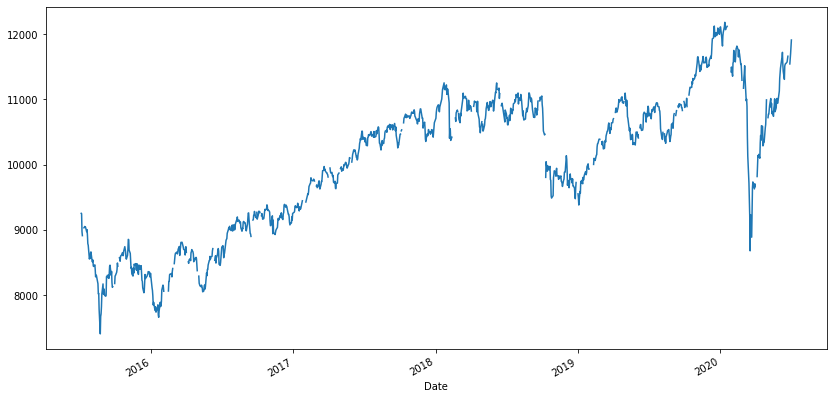

In [ ]:
df_many.Close['^TWII'].plot(figsize=(14,7))

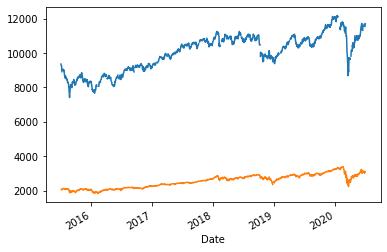

In [ ]:
df_many.Close['^TWII'].plot()
df_many.Close['^GSPC'].plot()

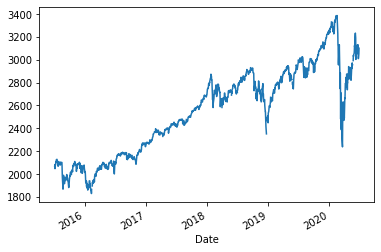

In [ ]:
df_many.Close['^GSPC'].plot()

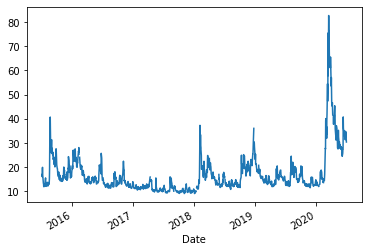

In [ ]:
df_many.Close['^VIX'].plot()

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


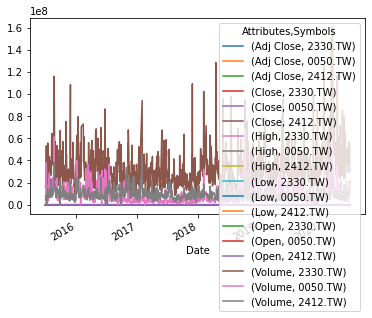

In [ ]:
import pandas_datareader as pdr
df_many = pdr.DataReader(['2330.TW', '0050.TW', '2412.TW'], 'yahoo')
df_many.plot()

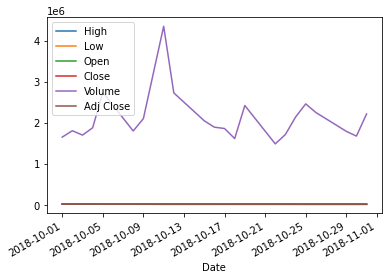

In [ ]:
startTime = '2018-10-01'
endTime = '2018-10-30'
df_2330 = pdr.DataReader('^TWII', 'yahoo', startTime, endTime)
df_2330.plot()

# 6. YAHOO股票代號查詢
https://finance.yahoo.com/world-indices/

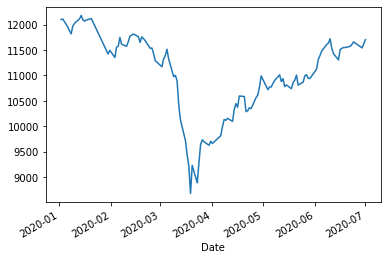

In [ ]:
startTime = '2020-01-01'
endTime = '2020-07-01'
df_twii = pdr.DataReader('^TWII', 'yahoo', startTime, endTime)
df_twii.Close.plot()

In [ ]:
df_2330.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-10-01,264.0,261.0,262.0,263.0,22254380,252.626572
2018-10-02,263.0,257.0,262.0,257.5,38391491,247.343506
2018-10-03,260.0,257.0,257.5,260.0,25228536,249.744904
2018-10-04,257.5,254.0,257.0,254.0,36408727,243.981567
2018-10-05,253.0,248.5,250.0,250.0,40204660,240.139328


In [ ]:
df_2330.describe()

,High,Low,Open,Close,Volume,Adj Close
count,22.000000,22.000000,22.000000,22.000000,2.200000e+01,22.000000
mean,240.045455,235.181818,237.545455,237.795455,4.025299e+07,228.416165
std,12.694120,13.061708,13.117517,12.685443,1.760988e+07,12.185095
min,222.000000,217.000000,220.500000,219.500000,1.846379e+07,210.842331
25%,233.625000,227.250000,229.625000,229.625000,2.888478e+07,220.567974
50%,237.000000,230.250000,233.000000,236.750000,3.810478e+07,227.411942
75%,246.125000,241.750000,245.000000,243.875000,4.386518e+07,234.255924
max,264.000000,261.000000,262.000000,263.000000,9.458966e+07,252.626572


#7. 去除多餘欄位drop, axis=1

In [ ]:
df=df_2330.drop(['Volume','Adj Close'],axis=1)

In [ ]:
df.sample(5)

,High,Low,Open,Close
Date,,,,
2018-10-05,253.0,248.5,250.0,250.0
2018-10-17,243.0,238.0,241.5,238.5
2018-10-03,260.0,257.0,257.5,260.0
2018-10-16,237.0,229.0,229.5,237.0
2018-10-30,225.0,220.5,221.0,223.0


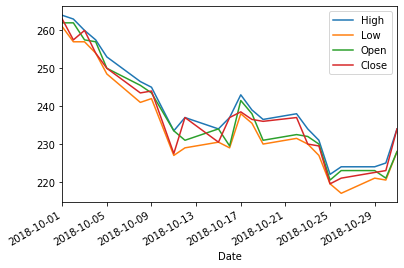

In [ ]:
df.plot()